# TF-IDF: Max Features

This notebook tests different max feature values when using TF-IDF and a bagging classifier on a [Kaggle essay scores](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2) dataset of ~17,000 essays. The results seem to suggest that a higher max features value leads to better results.

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('data/train.csv')
train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


## Preprocess Text

In [2]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):

    # removes unprintable characters
    unprintable = r"[^\w\s]"
    text = re.sub(unprintable, '', text)

    # removes non-breaking space characters
    non_breaking = '\xa0'
    text = re.sub(non_breaking, ' ', text)

    # removes newline characters
    newline = '\n'
    text = re.sub(newline, ' ', text)

    # removes punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # lowercase the text
    text = text.lower()
    
    # tokenization
    tokens = word_tokenize(text)
    
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

train['full_text'] = [preprocess_text(x) for x in train['full_text']]

## Drop misspellings

In [3]:
from spellchecker import SpellChecker

# creates a spellckecker object
spell = SpellChecker()

# returns a count of misspelled words
def misspellings(essay, drop=True):

    # the essay is split into words
    words = essay.split()

    # either drops or corrects unknown words
    final_words = []
    if drop == True:
        # loops through each word
        for word in words:
            
            # checks if the word is known
            if spell.known([word]):
                
                # appends to a list of words to return
                final_words.append(word)
    
    else:
        # loops through each word
        for word in words:
            
            # checks if the word is known
            if spell.known([word]):
                
                # appends to a list of words to return
                final_words.append(word)

            else:
                # attempts to correct the word
                correction = spell.correction(word)

                # appends the correction if one was found
                if correction != None:
                    # appends to a list of words to return
                    final_words.append(correction)

    # joins the words back together with a space 
    return ' '.join(final_words)

train['full_text'] = [misspellings(x) for x in train['full_text']]

## Fit model

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier  
from sklearn.svm import SVC  
from sklearn.metrics import cohen_kappa_score

def fit_model(max_features):

    # a text vectorizer with a variable n-gram range is specified
    text_vectorizer = TfidfVectorizer(
    stop_words='english',
    sublinear_tf=False,
    strip_accents='unicode',
    binary=True,
    analyzer='word',
    token_pattern=r'\w{2,}',  
    ngram_range=(1, 2),
    norm='l1', 
    use_idf=False, 
    smooth_idf=False,
    max_features=max_features,
    min_df=30)

    # vectorises the train text
    x = text_vectorizer.fit_transform(train['full_text'])
    y = train['score']

    # splits the data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
    
    # fits a bagging model 
    model = BaggingClassifier(estimator=SVC(C=1.75, 
                                            kernel='rbf', 
                                            gamma='scale', 
                                            decision_function_shape='ovr', 
                                            random_state=123, 
                                            tol=1e-5, 
                                            shrinking=True, 
                                            verbose=True, 
                                            break_ties=True), 
                              n_estimators=10, 
                              random_state=123, 
                              verbose=3) 
    
    model.fit(x_train, y_train.values.ravel())

    # predicts test values
    y_pred_bag = model.predict(x_test)

    # evaluates predictions with the quadratic weighted Cohen Kappa
    score = cohen_kappa_score(y_test.values.ravel(), y_pred_bag.ravel(), weights='quadratic')
    
    return score
    
# loops through each max feature, vectorising text, fitting a model and evaluating performance
max_features = [100, 200, 300, 400, 500]
averages = []
for max_feature in max_features:
    score = fit_model(max_feature)
    averages.append(score)

Building estimator 1 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 2 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 3 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 4 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 5 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 6 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 7 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 8 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 9 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 10 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 1 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 2 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 3 of 10 for this parallel run (total 10)...
[LibSVM]Building estimator 4 of 10 for this parallel run (total 10)...
[LibSVM]Build

## Visualize results

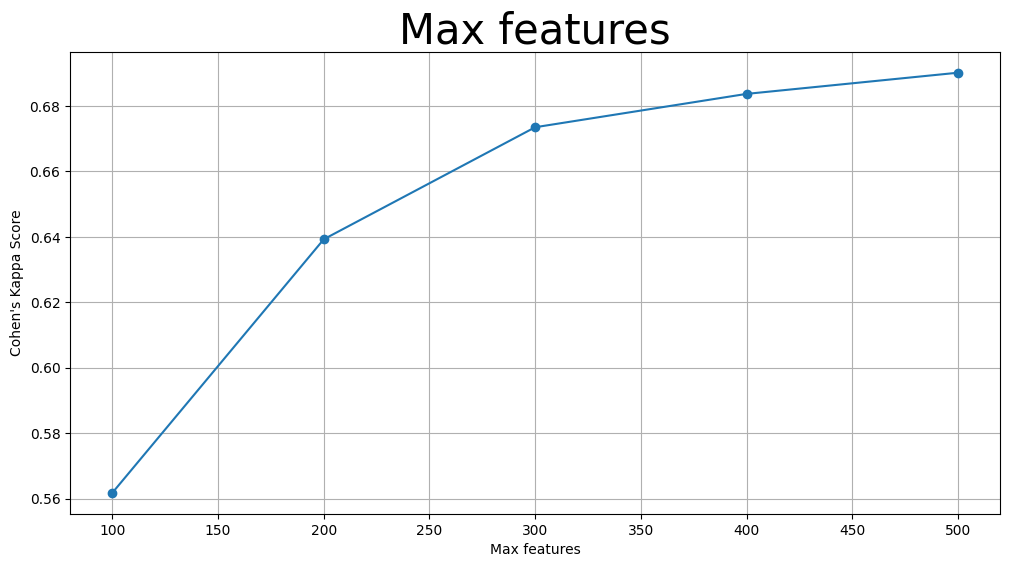

In [5]:
import matplotlib.pyplot as plt

# plots the results
plt.figure(figsize=(12, 6));
plt.plot(max_features, averages, marker='o', linestyle='-');
plt.xlabel('Max features');
plt.ylabel('Cohen\'s Kappa Score');
plt.title('Max features', size=30);
plt.grid(True);
plt.show();